In [1]:
import numpy as np

import jax
from jax import numpy as jnp, random as jr

import optax

from env import Env
from svae.inference import make_gradfun
from svae.utils import split_into_batches
from svae.models.hmm import run_inference, init_pgm_param
from network import init_mlp, identity, make_loglike

import matplotlib.pyplot as plt

In [2]:
key = jr.PRNGKey(0)
batch_dim = 64
num_epochs, num_samples, num_steps = 2000, 1000, 8

env = Env()

data_key, key = jr.split(key)
data, actions = env.sample(data_key, num_samples, num_steps)
data = data.reshape(num_samples, num_steps, -1)

batch_key, key = jr.split(key)
(data_batches, action_batches), num_batches = split_into_batches(batch_key, (data, actions), batch_dim)
get_batch = lambda i: data_batches[i % num_batches]
get_action_batch = lambda i: action_batches[i % num_batches]

In [3]:
def test(params, data, env, key):
    infer_key, key = jr.split(key)
    pgm_params, decoder_params, encoder_params = params

    idx = np.random.randint(data.shape[0])
    test_data = data[idx : idx+1, :]

    node_potentials = encoder(encoder_params, test_data)
    samples, _, _, _ = run_inference(infer_key, pgm_prior_params, pgm_params, node_potentials)
    decoded = decoder(decoder_params, samples)

    env.plot_sample(test_data.reshape(-1, 10, 10))
    env.plot_sample(decoded.reshape(-1, 10, 10))

    probs = pgm_params[1] / jnp.sum(pgm_params[1], axis=-1, keepdims=True)
    plt.imshow(probs)
    plt.colorbar()
    plt.axis("off")
    plt.show()

532048.6 -0.0 -34.933598
epoch 0: 532.01


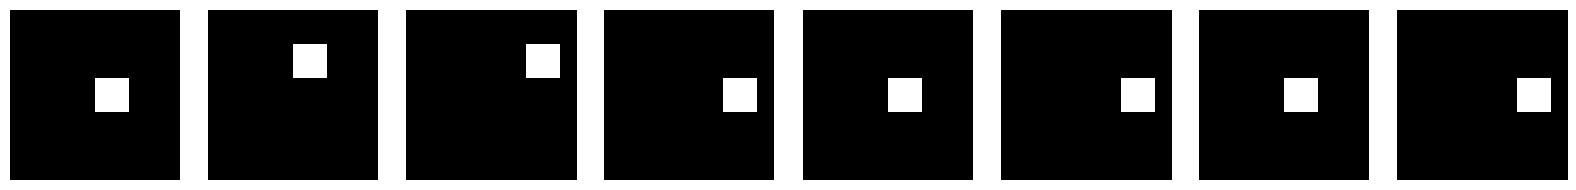

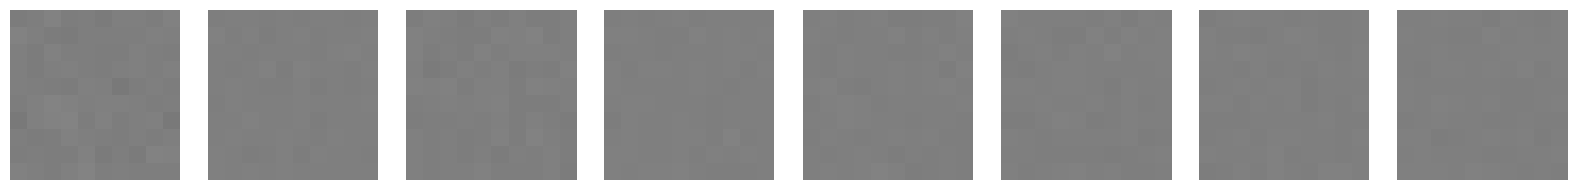

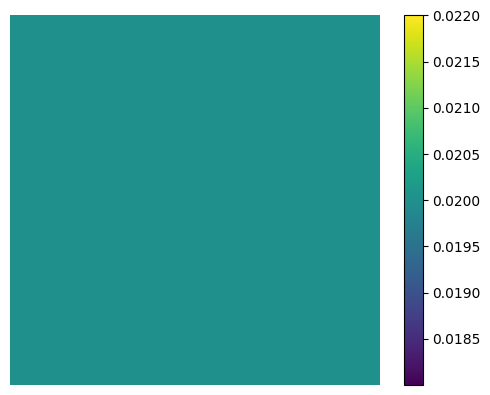

528989.5 -0.0026988983 -35.16951
525913.7 6.2942505e-05 -35.12033
522690.47 0.0052223206 -35.2265
519282.53 0.004798889 -35.3293
515742.84 0.013889313 -35.231586
511861.94 0.009075165 -35.30664
507663.5 0.015640259 -35.240993
503053.2 0.016426086 -35.21712
498065.1 0.017997742 -35.183758
492682.78 0.025100708 -35.02732
486730.75 0.026992798 -34.914997
480408.8 0.03655243 -34.698143
473588.9 0.03703308 -34.3667
466172.88 0.042816162 -34.05433
458158.16 0.044891357 -33.750774
449562.47 0.053085327 -33.042286
440588.3 0.060668945 -32.405827
431023.72 0.06452942 -31.595642
420871.34 0.070114136 -30.88802
410369.66 0.07972717 -29.289587
399384.03 0.08128357 -28.327911
387818.7 0.09223938 -26.395704
375882.78 0.10290527 -24.961382
363526.47 0.10913086 -22.441563
351044.12 0.1194458 -20.338737
338120.38 0.12747192 -17.420576
325156.0 0.13522339 -13.989505
312197.4 0.14123535 -9.929227
298957.75 0.15316772 -5.3111057
285855.53 0.15774536 -0.602014
272827.94 0.17303467 6.474622
260231.19 0.1821

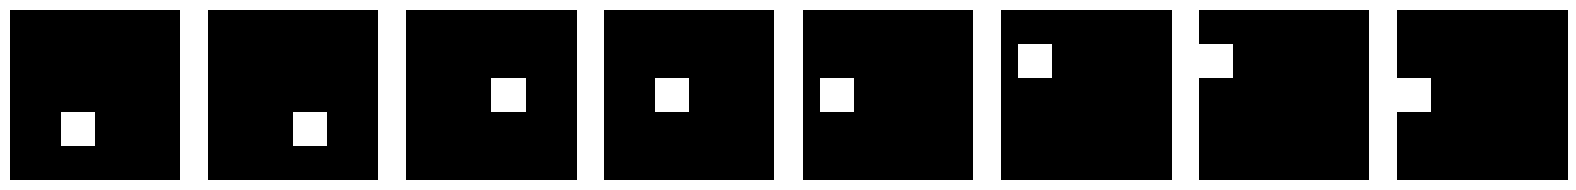

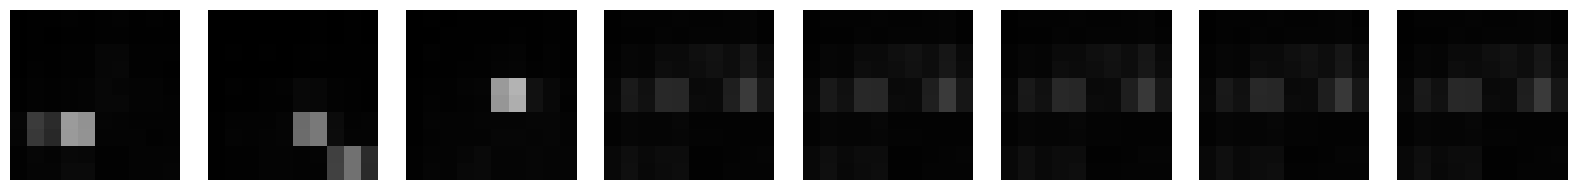

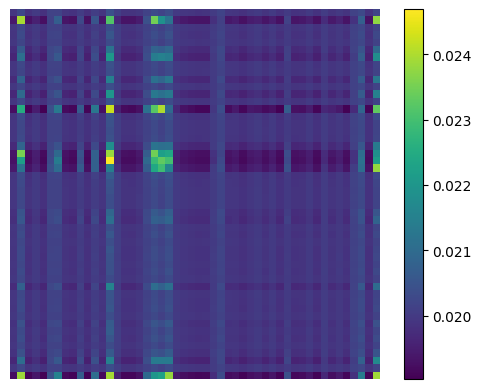

72864.59 1.0600891 749.199
67192.77 1.0674133 765.87756
74628.45 1.0721436 711.8771
67681.62 1.0759888 750.9208
72420.61 1.0783997 716.7113
71121.055 1.0813904 730.0307
71522.22 1.0911255 712.623
71473.664 1.092102 703.79474
70474.64 1.0995483 715.71405
70935.45 1.1058044 712.0733
66354.79 1.1073608 736.36426
71283.555 1.1180725 690.275
72626.336 1.1190186 673.5676
70102.99 1.1282043 700.2996
65369.59 1.1340942 722.0929
69803.98 1.136383 689.6862
64151.344 1.1436462 706.261
71738.32 1.1495056 653.07574
64793.87 1.1539612 690.92377
69492.92 1.1598206 658.19696
68511.8 1.1671753 668.5214
68800.69 1.1775513 652.8352
69072.83 1.1770935 643.5198
67986.49 1.1862183 653.85266
68436.23 1.1918945 648.83765
64015.58 1.2026367 673.6817
69137.72 1.2076416 630.0973
70263.53 1.2139282 615.55524
67826.66 1.222992 638.7548
63263.89 1.2252197 660.7629
67729.45 1.2307739 629.3063
62152.25 1.2443237 645.92847
69701.66 1.2507935 594.78766
62924.555 1.2550659 631.52795
67429.17 1.2616577 600.85016
66778.98

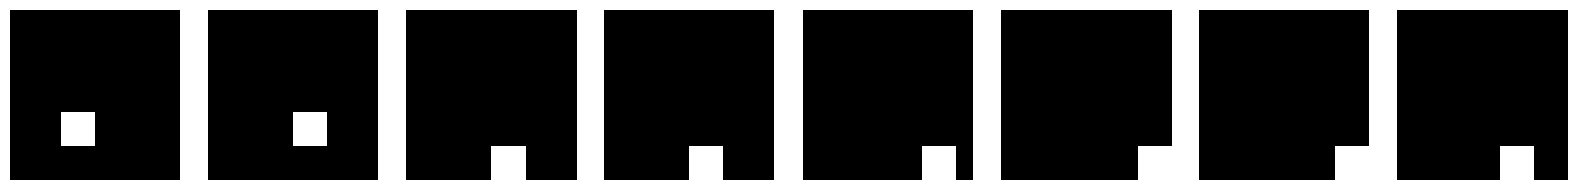

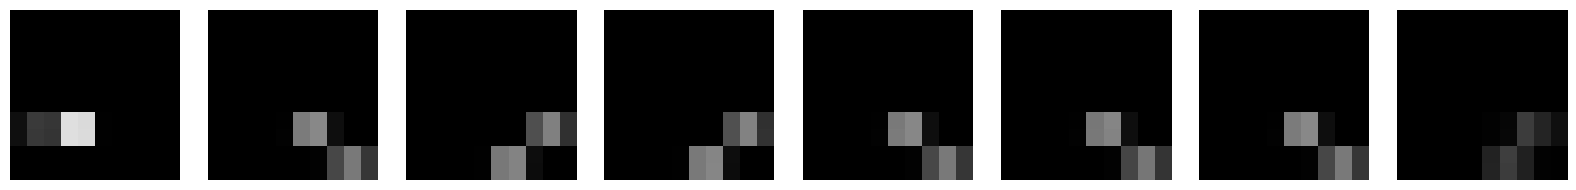

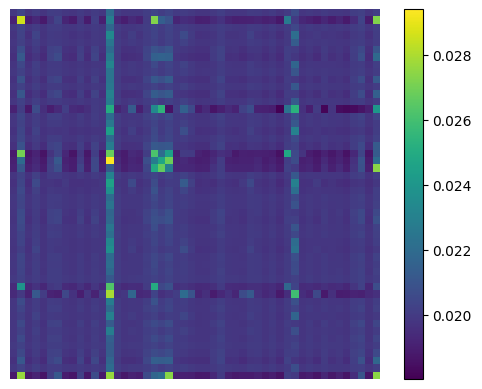

57607.504 2.7233887 92.0884
57651.523 2.7334595 86.21934
58279.42 2.7457886 78.41708
56360.348 2.755066 110.78761
57684.758 2.7651978 75.54987
54705.01 2.7686768 71.94302
58024.875 2.782959 96.61703
58225.496 2.7930908 94.31282
57017.996 2.800415 83.36334
54441.82 2.8083496 57.727253
57102.46 2.8154297 64.626205
52472.887 2.8253784 61.411358
58093.277 2.8353271 72.711266
53144.273 2.847351 57.15193
55539.793 2.854004 64.752174
56313.082 2.8693237 40.374474
56516.688 2.8753052 32.726357
57246.98 2.887207 21.900064
55430.324 2.8928223 51.6053
56636.215 2.9036865 15.761043
53702.94 2.9110107 8.792238
57163.676 2.9234009 32.298717
57192.656 2.9337158 31.119844
55937.973 2.9383545 19.359829
53608.805 2.9493408 -9.7308035
56042.938 2.9611206 0.83737403
51464.047 2.9691772 -5.4843
56910.85 2.980896 9.56457
51943.09 2.9885254 -8.795251
54507.57 2.996643 -0.8206223
55223.66 3.0123901 -25.97065
55574.23 3.0205078 -34.673046
56428.555 3.0239258 -47.19318
54719.79 3.0372925 -18.285027
55784.63 3.0

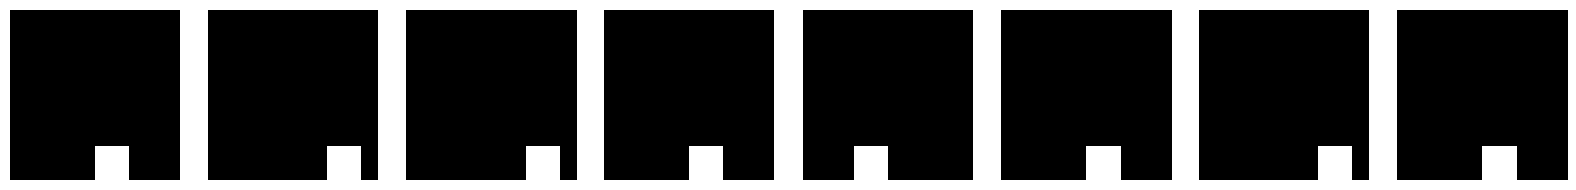

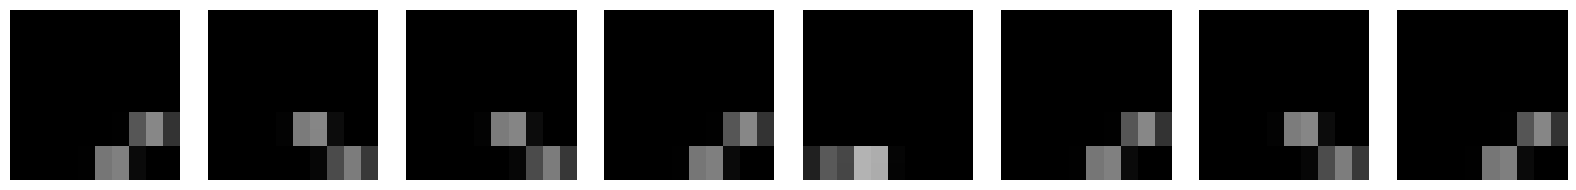

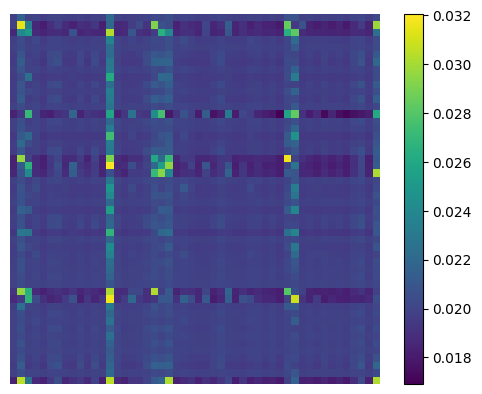

46356.543 5.397461 -1289.9989
50369.965 5.412903 -1281.2959
49353.984 5.433777 -1243.9592
47175.293 5.4451294 -1277.3733
46096.984 5.4612427 -1311.4629
47934.91 5.479004 -1308.5383
44682.83 5.493408 -1358.091
49594.168 5.5093994 -1297.1409
44414.85 5.526428 -1355.742
47498.203 5.540344 -1340.4209
48384.58 5.5635376 -1411.8948
49207.316 5.581421 -1386.7883
50371.098 5.598633 -1448.8008
47937.586 5.610962 -1395.0212
48791.676 5.628845 -1445.0516
46066.68 5.6469727 -1451.0243
50062.758 5.661682 -1442.3087
49045.273 5.682007 -1401.2002
46848.363 5.6955566 -1441.2184
45835.8 5.7125854 -1474.5177
47616.086 5.7318726 -1471.0459
44425.797 5.7547607 -1523.669
49307.336 5.7701416 -1456.5331
44174.305 5.786316 -1520.8071
47258.895 5.8079834 -1504.3625
48143.504 5.821472 -1580.077
48971.4 5.842102 -1549.4395
50100.617 5.861145 -1618.7401
47668.207 5.878662 -1566.0956
48555.996 5.8953857 -1618.0546
45813.223 5.918396 -1625.3164
49804.195 5.9334717 -1618.2684
48786.742 5.9539185 -1573.2921
46602.094

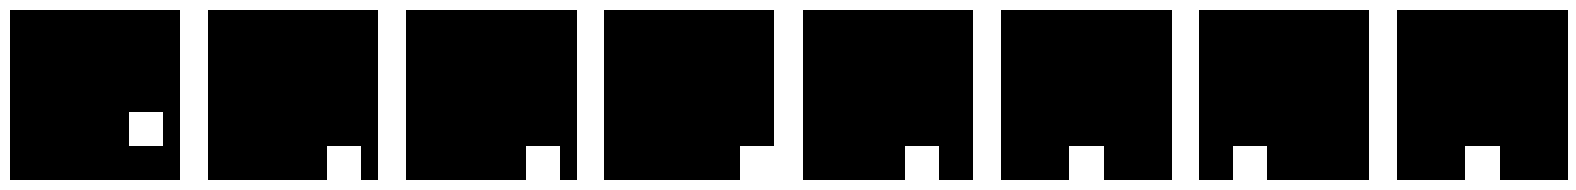

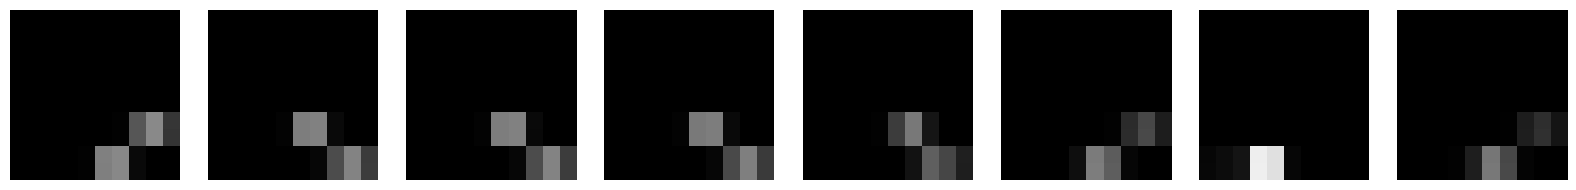

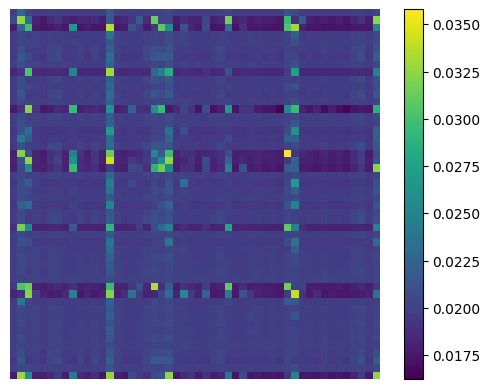

42382.816 9.622864 -3987.0845
40241.562 9.648193 -4069.1729
43924.438 9.670105 -3937.803
40142.676 9.699829 -4073.7676
41387.168 9.7178955 -4037.2769
43473.758 9.740601 -4158.846
42934.56 9.766907 -4057.7683
44602.64 9.792969 -4217.4077
42436.6 9.8168335 -4161.281
41982.652 9.840454 -4213.3906
41312.348 9.867981 -4227.69
44897.5 9.893005 -4231.353
44685.332 9.918701 -4141.4062
41220.85 9.942078 -4260.864
41625.695 9.971558 -4264.6855
42097.6 9.991638 -4246.972
40063.234 10.017212 -4329.0933
43649.055 10.047302 -4187.033
40091.12 10.077698 -4328.8213
41209.754 10.098206 -4287.1895
43219.133 10.124329 -4408.552
42625.88 10.152283 -4303.385
44406.945 10.179016 -4468.7246
42148.04 10.204468 -4410.9707
41688.75 10.23053 -4469.885
41107.703 10.26062 -4487.9873
44491.43 10.285889 -4487.664
44433.59 10.312134 -4396.482
40888.945 10.345703 -4528.531
41374.25 10.370056 -4528.0913
41801.188 10.397949 -4511.335
39793.477 10.426025 -4590.857
43325.34 10.4557495 -4448.017
39991.586 10.485718 -4593.3

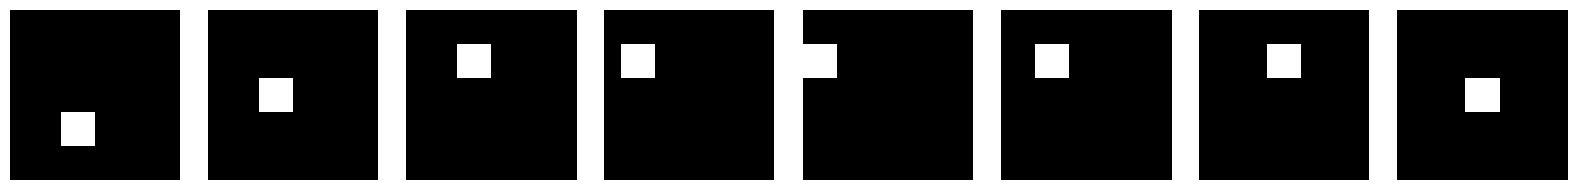

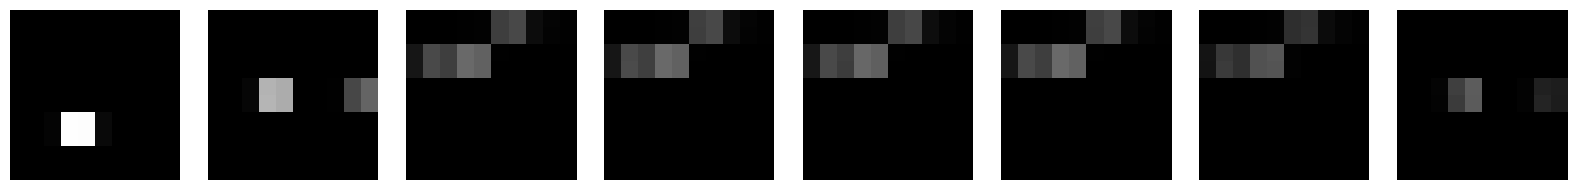

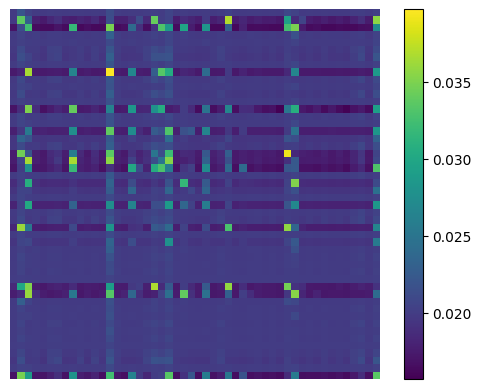

26084.469 15.874207 -7283.38
27027.396 15.903015 -7199.272
27743.727 15.935608 -7353.957
26394.28 15.969666 -7340.0786
28243.781 15.998169 -7394.588
24254.988 16.031311 -7397.936
28126.713 16.059998 -7398.652
28706.76 16.091064 -7300.029
26238.77 16.122192 -7494.163
23120.22 16.15326 -7438.038
26740.879 16.179321 -7455.1157
22290.115 16.213867 -7489.956
28948.025 16.24585 -7336.7666
23340.969 16.275024 -7526.2397
25543.814 16.310547 -7462.4404
25148.797 16.341187 -7549.3496
25869.873 16.372437 -7461.417
27269.334 16.403809 -7629.5107
25713.508 16.431946 -7608.631
27658.223 16.46576 -7656.782
22976.316 16.496704 -7660.3447
27021.527 16.532349 -7665.7417
27613.44 16.557556 -7567.456
25574.004 16.58844 -7753.1523
22221.12 16.620178 -7691.154
25489.492 16.652588 -7702.958
21296.686 16.682312 -7738.4785
28071.943 16.712952 -7587.735
22484.006 16.7417 -7766.975
24918.78 16.780823 -7701.841
23858.078 16.805725 -7791.635
24877.508 16.840942 -7700.1436
25918.648 16.875793 -7867.5303
24787.742 1

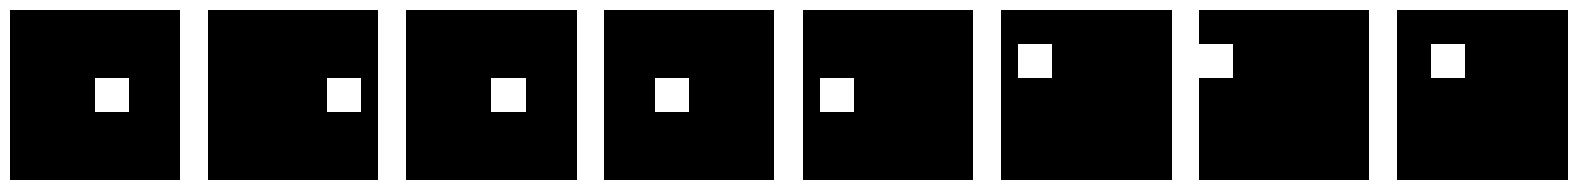

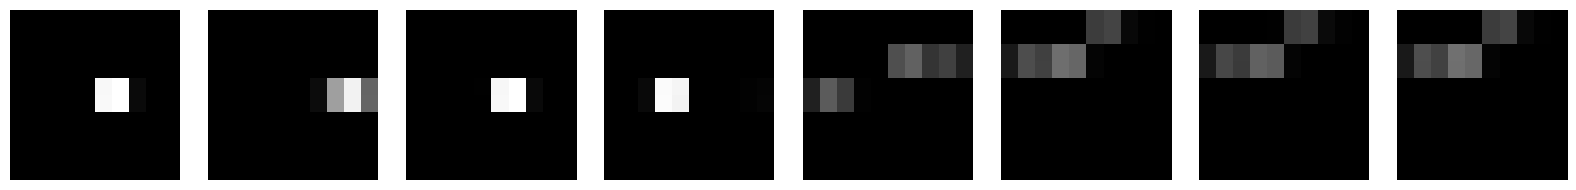

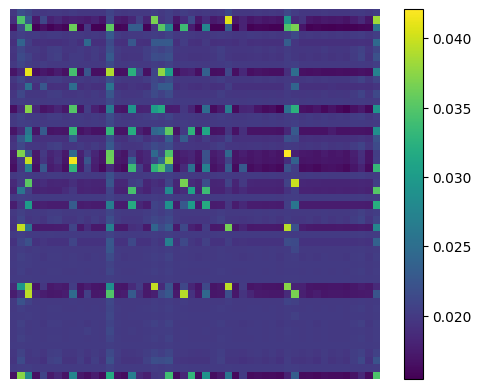

17879.078 21.920837 -10911.759
23583.846 21.958496 -10829.837
23216.166 21.98822 -10792.992
21894.799 22.023438 -11014.378
18840.36 22.056885 -10931.331
21354.742 22.090149 -10951.382
17091.078 22.123352 -10983.962
23108.037 22.15509 -10781.404
17019.031 22.191284 -11012.693
20531.752 22.224304 -10932.363
20079.303 22.2583 -11027.127
20723.66 22.288147 -10902.574
21194.977 22.323608 -11073.298
20940.861 22.358276 -11080.364
21458.86 22.390991 -11151.319
17396.871 22.42511 -11177.524
21504.955 22.457153 -11093.367
22512.045 22.493652 -11069.179
20997.059 22.528748 -11296.515
18212.062 22.562683 -11209.041
20539.953 22.59497 -11235.176
16467.932 22.631958 -11266.699
22906.033 22.66742 -11064.222
16526.768 22.69806 -11305.714
19818.318 22.730164 -11230.358
19509.674 22.76831 -11330.028
19999.613 22.796509 -11207.467
20373.275 22.836914 -11389.397
20084.832 22.867004 -11378.183
21073.5 22.906616 -11450.59
16838.742 22.941284 -11483.368
21352.98 22.971619 -11377.607
21621.404 23.003357 -113

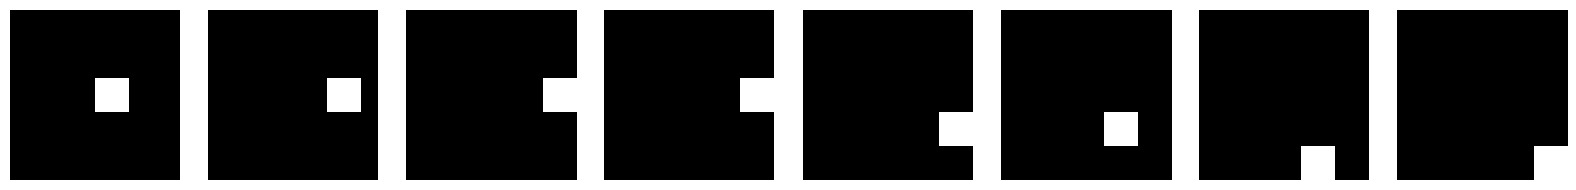

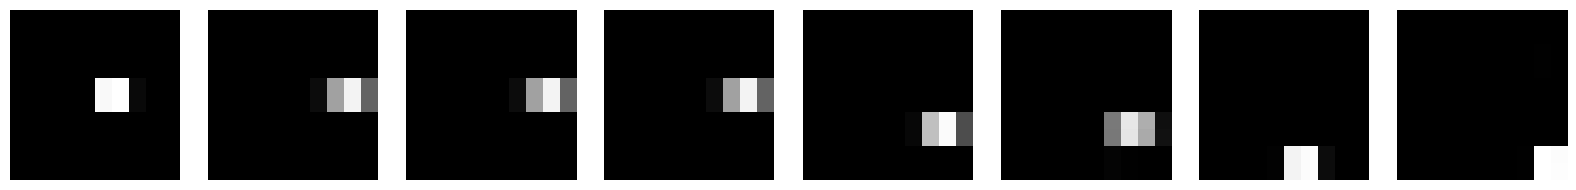

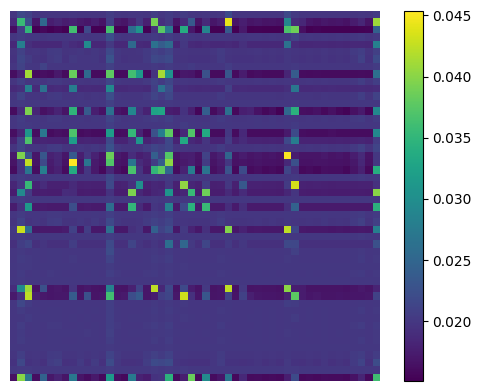

17826.447 28.786621 -14932.305
14518.263 28.820984 -14962.061
21097.084 28.865051 -14678.15
14864.621 28.898987 -14998.998
17846.016 28.938354 -14908.14
16712.984 28.974854 -15007.769
17717.766 29.00879 -14858.876
18347.068 29.047241 -15041.479
17822.3 29.08496 -15007.994
18900.309 29.12384 -15112.77
14806.384 29.158752 -15182.046
20300.684 29.198303 -14974.241
18774.371 29.234863 -15066.431
18098.258 29.27472 -15288.478
14931.906 29.311157 -15188.619
17213.682 29.345947 -15250.44
14127.043 29.387268 -15276.854
20603.629 29.42743 -15014.137
14259.746 29.460938 -15326.007
17799.162 29.499634 -15245.106
16862.36 29.536255 -15338.574
17713.86 29.575012 -15182.132
18349.992 29.613342 -15365.34
17723.174 29.651794 -15333.913
18976.373 29.685669 -15436.214
14712.957 29.726624 -15509.848
19596.322 29.763 -15295.993
18610.547 29.801086 -15392.245
18161.832 29.836182 -15615.214
14872.362 29.875916 -15521.639
17433.92 29.913147 -15590.028
14133.722 29.949646 -15610.686
20686.055 29.987793 -15327

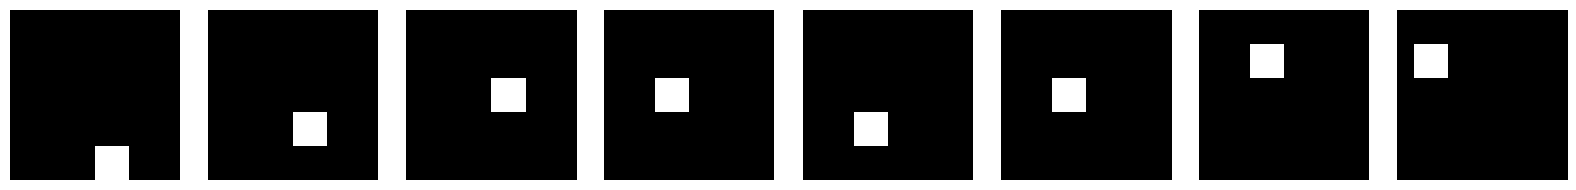

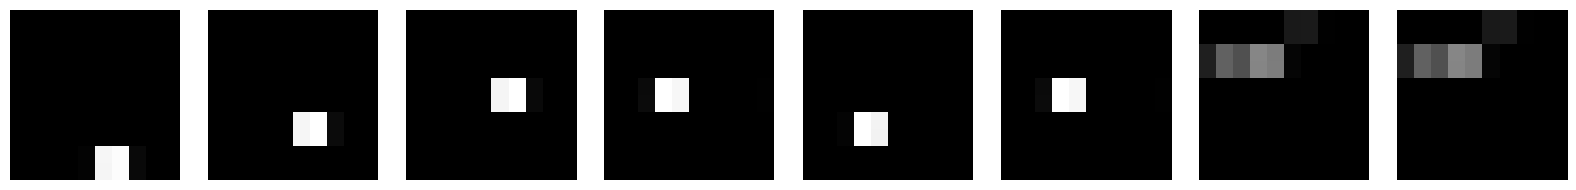

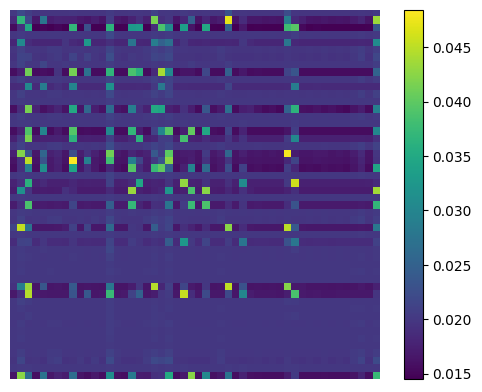

14221.123 36.525513 -19282.854
15561.469 36.56659 -19072.16
15823.648 36.604126 -19298.63
15306.069 36.643738 -19242.697
15168.862 36.683777 -19383.266
13142.729 36.722717 -19484.61
16463.56 36.760803 -19141.447
16387.088 36.79706 -19300.037
15476.405 36.839478 -19571.76
12734.892 36.881775 -19479.76
15217.018 36.922363 -19588.22
12008.855 36.961304 -19561.402
17402.934 36.998047 -19219.9
12137.206 37.038635 -19633.006
15098.868 37.0813 -19524.738
13920.746 37.12329 -19620.97
15284.242 37.16284 -19405.225
16265.874 37.201233 -19625.893
15309.985 37.23694 -19568.682
15224.355 37.28308 -19718.314
12644.766 37.322388 -19826.994
16520.97 37.35968 -19462.977
16479.092 37.399475 -19638.123
16195.128 37.444275 -19900.104
12642.482 37.486755 -19802.113
15291.194 37.52484 -19924.06
11694.608 37.562134 -19890.426
17699.012 37.602722 -19544.377
12212.225 37.64557 -19972.309
15563.544 37.6864 -19868.553
14291.034 37.723694 -19971.912
15320.451 37.762573 -19752.465
15164.582 37.804443 -19985.123
14

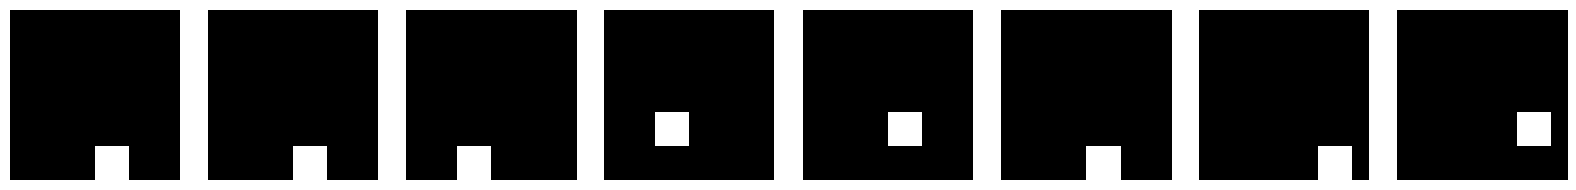

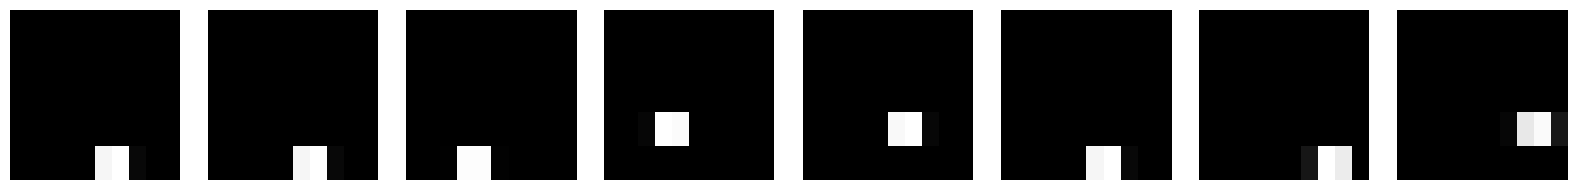

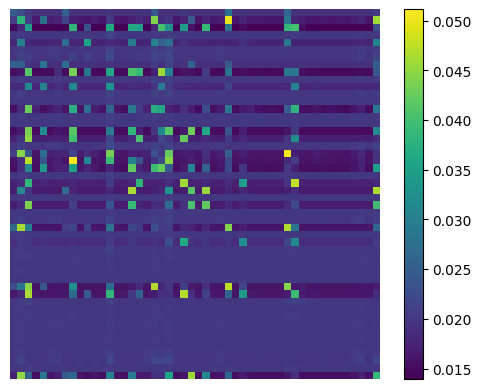

11839.035 44.959045 -23973.52
13706.684 45.000854 -23462.31
14454.925 45.045288 -23691.363
13536.503 45.09027 -23966.955
11194.039 45.133484 -23936.494
13334.601 45.182617 -24082.924
10943.045 45.22455 -24023.738
16297.324 45.26465 -23562.51
11048.747 45.303894 -24104.494
14116.754 45.349854 -23953.19
12565.582 45.39331 -24052.453
13666.883 45.439026 -23794.053
14292.542 45.483093 -24044.936
13120.924 45.523865 -23997.742
12591.303 45.568054 -24156.572
11681.752 45.609314 -24324.488
12896.843 45.65564 -23812.701
14773.715 45.697998 -24041.143
13123.198 45.743042 -24316.053
11339.252 45.783813 -24297.117
13696.641 45.831177 -24455.11
11036.0625 45.872864 -24398.906
14827.365 45.919067 -23912.402
10603.149 45.958374 -24466.332
13369.748 46.00763 -24305.916
12071.287 46.044495 -24397.932
13106.143 46.09308 -24136.139
14041.384 46.139526 -24388.518
12668.326 46.184937 -24345.076
12495.491 46.228638 -24505.084
11565.612 46.274536 -24686.207
12782.08 46.319458 -24167.46
13959.115 46.36786 -2

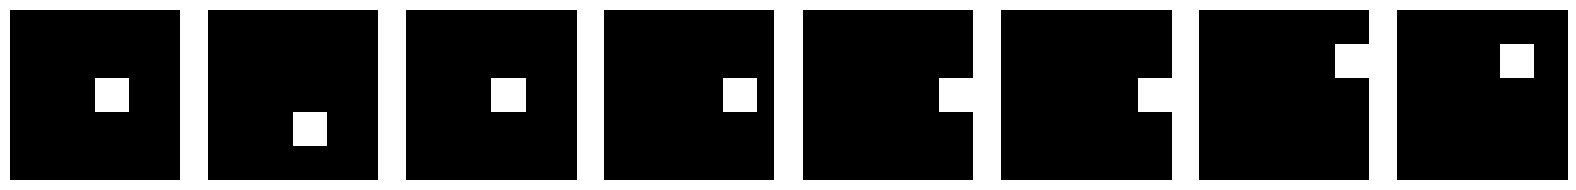

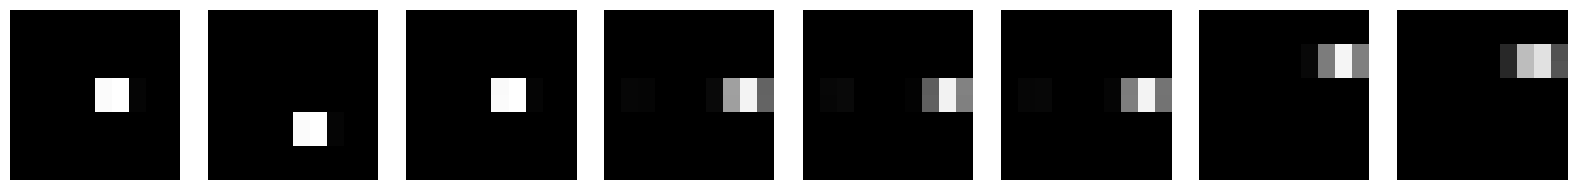

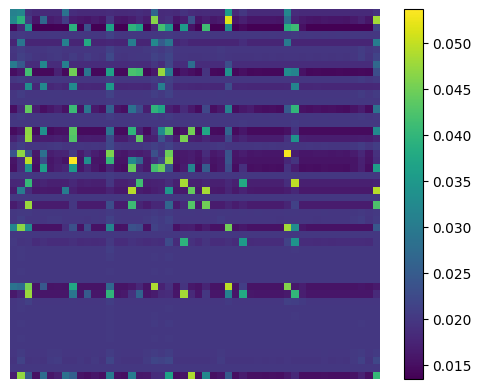

11677.772 54.12848 -28928.219
9467.038 54.177673 -28856.617
13176.864 54.22528 -28285.166
9631.153 54.273254 -28950.686
12326.085 54.318726 -28752.777
11368.513 54.36615 -28852.188
12122.874 54.413696 -28551.17
12254.322 54.463623 -28853.096
11678.123 54.509155 -28773.629
11479.147 54.55316 -28967.318
10388.179 54.605774 -29217.3
12123.754 54.65381 -28533.37
12315.362 54.70044 -28849.215
11068.402 54.749268 -29114.719
10098.156 54.801025 -29157.273
11945.985 54.85132 -29331.277
9082.99 54.9032 -29275.473
12404.784 54.943726 -28679.734
9504.673 54.989624 -29364.309
11972.838 55.036255 -29161.363
10702.124 55.08606 -29248.418
11767.724 55.133667 -28945.96
11792.453 55.183716 -29250.18
11552.132 55.227905 -29172.514
11610.802 55.27527 -29368.424
10347.19 55.325195 -29629.932
12460.084 55.372192 -28921.824
12108.139 55.42041 -29253.732
11985.0 55.467896 -29529.809
10138.152 55.519165 -29583.955
11455.568 55.566406 -29755.506
9185.141 55.618652 -29692.604
12864.633 55.664062 -29081.656
9459

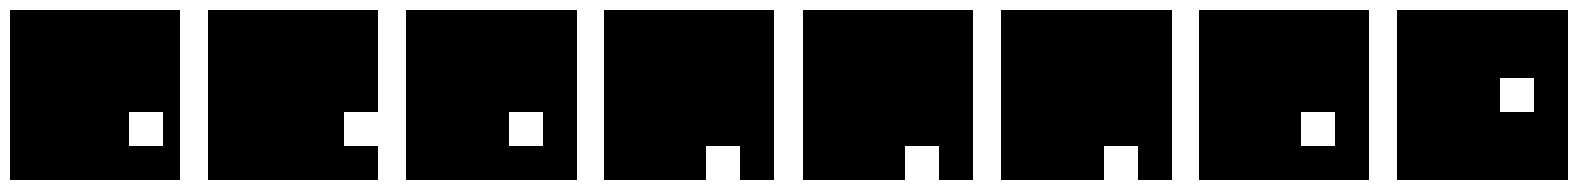

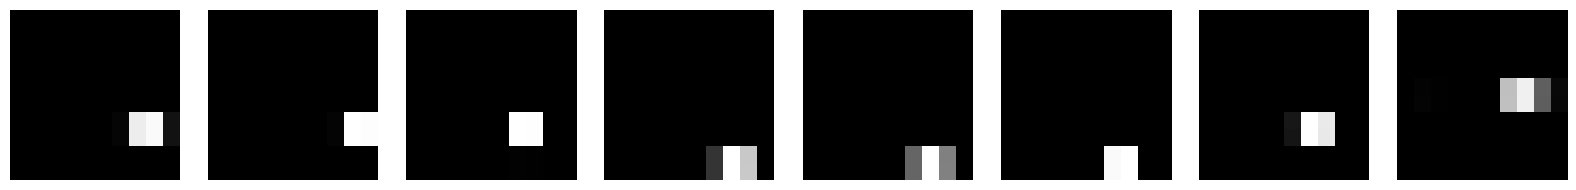

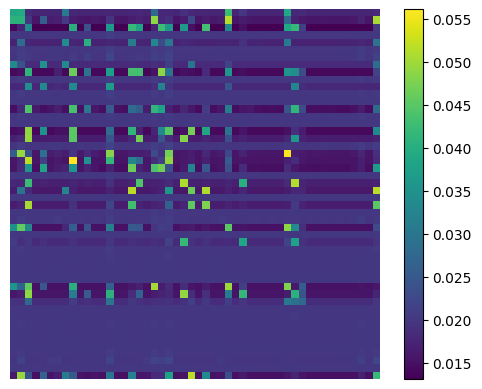

10814.903 63.28589 -33954.875
11221.218 63.334595 -33632.855
10694.689 63.383667 -33987.996
10675.906 63.43274 -33879.055
10859.676 63.480713 -34107.664
9365.16 63.5271 -34449.97
12611.049 63.575806 -33523.684
10749.444 63.622314 -33925.254
10362.681 63.672974 -34202.438
9224.741 63.721924 -34354.176
11916.742 63.765015 -34531.277
8221.055 63.80835 -34502.08
11542.304 63.86084 -33734.105
8502.575 63.911987 -34606.22
9808.148 63.957764 -34330.414
10124.771 64.006226 -34390.914
10626.482 64.05286 -34074.938
10274.024 64.10608 -34416.664
10345.392 64.15735 -34323.926
9778.616 64.20239 -34560.438
9652.977 64.24951 -34913.79
12047.658 64.30249 -33964.42
10081.796 64.34863 -34381.13
10193.6 64.39636 -34644.098
9457.039 64.44446 -34812.156
11139.358 64.497925 -34983.367
8097.812 64.54614 -34961.03
11196.288 64.59204 -34175.113
8691.188 64.643555 -35060.65
10335.438 64.69751 -34763.973
9847.319 64.74109 -34834.605
10934.676 64.791504 -34494.92
10497.062 64.84094 -34848.875
10177.037 64.88928 -

KeyboardInterrupt: 

In [4]:
num_epochs = 5000
K, D = 50, 100

prior_key, key = jr.split(key)
pgm_prior_params = init_pgm_param(prior_key, K, alpha=1.0)

encoder_key, key = jr.split(key)
encoder, encoder_params = init_mlp(encoder_key, D, [(512, jax.nn.relu), (K, identity)])

decoder_key, key = jr.split(key)
decoder, decoder_params = init_mlp(decoder_key, K, [(512, jax.nn.relu), (D, jax.nn.sigmoid)])
loglike = make_loglike(decoder)

pgm_key, key = jr.split(key)
pgm_params = init_pgm_param(pgm_key, K, alpha=1.0)
params = pgm_params, decoder_params, encoder_params

grad_key, key = jr.split(key)
gradfun = make_gradfun(grad_key, run_inference, encoder, loglike, pgm_prior_params, 1, num_samples, num_batches, 1e4)

optim = optax.adam(learning_rate=1e-3)
opt_state = optim.init(params)

for epoch in range(num_epochs):
    grads, elbo = gradfun(params, get_batch(epoch))
    updates, opt_state = optim.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)

    if epoch % 200 == 0:
        print(f"epoch {epoch}: {elbo:.2f}")
        test(params, data, env, key)